# Wear the Mask! Convolutional Neural Network (CNN) - wearthemask.herokuapp.com

## Model development (October, 2021)
(The web application will migrate to other server because of its perfomance there, I am researching to find another low-cost solution.)<br>
The data set was obtained from Wang, Z. et al., 2020 (https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset)<br>
<br>
This notebook is a kind of project that I thought about this context of pandemics. The main objective is to develop an easy but useful model to detect if a person is wearing the mask or not and then use it in production, in this link wearthemask.heroku.com, for potential employers as part of my portfolio. If you want to contact me, please, send me a email to rolando.duartemejias@gmail.com

## Importing libraries

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Preprocessing
This step is important to know more about dataset and take decisions in the model development later

### Obtaining the directory of the images and their class (1: mask, 0: no mask)
in addition, deleting some images that cause errors in the model development.

In [2]:
os.chdir("./Images/")

In [3]:
trueDir = [x[0] for x in os.walk(".\\True\\")]
falseDir = [x[0] for x in os.walk(".\\False\\")]
trueFiles = []
falseFiles = []
allImagePathsTrue = {}
allImagePathsFalse = {}

for folder in trueDir:
    trueFilesTemp = os.listdir(folder)
    trueFiles.extend(trueFilesTemp)
    allImagePathsTemp = {os.path.basename(x): x for x in 
                   glob(os.path.join(folder, '*.jpg'))}
    allImagePathsTrue = {**allImagePathsTrue, **allImagePathsTemp}
    
for folder in falseDir:
    falseFilesTemp = os.listdir(folder)
    falseFiles.extend(falseFilesTemp)
    allImagePathsTemp = {os.path.basename(x): x for x in 
                   glob(os.path.join(folder, '*.jpg'))}
    allImagePathsFalse = {**allImagePathsFalse, **allImagePathsTemp}

trueLabels = np.ones((1, len(trueFiles)))
falseLabels = np.zeros((1, len(falseFiles)))
files = np.append(trueFiles, falseFiles)
filesLabels = np.append(trueLabels, falseLabels)
allImagePaths = {**allImagePathsTrue, **allImagePathsFalse}
df = pd.DataFrame({"Files": files, "Labels": filesLabels})
df["Labels"] = df["Labels"].astype(int)
df['Path'] = df["Files"].map(allImagePaths.get)
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92586 entries, 481 to 93611
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Files   92586 non-null  object
 1   Labels  92586 non-null  int32 
 2   Path    92586 non-null  object
dtypes: int32(1), object(2)
memory usage: 2.5+ MB


In [4]:
df.sample(5)

,Files,Labels,Path
81165,1_0_zhanghan_0099.jpg,0,.\False\zhanghan\1_0_zhanghan_0099.jpg
31271,1_0_leijiayin_0118.jpg,0,.\False\leijiayin\1_0_leijiayin_0118.jpg
61861,1_0_wangqing_0025.jpg,0,.\False\wangqing\1_0_wangqing_0025.jpg
68444,1_0_xiena_0046.jpg,0,.\False\xiena\1_0_xiena_0046.jpg
48914,1_0_pubajia_0013.jpg,0,.\False\pubajia\1_0_pubajia_0013.jpg


0    90468
1     2118
Name: Labels, dtype: int64


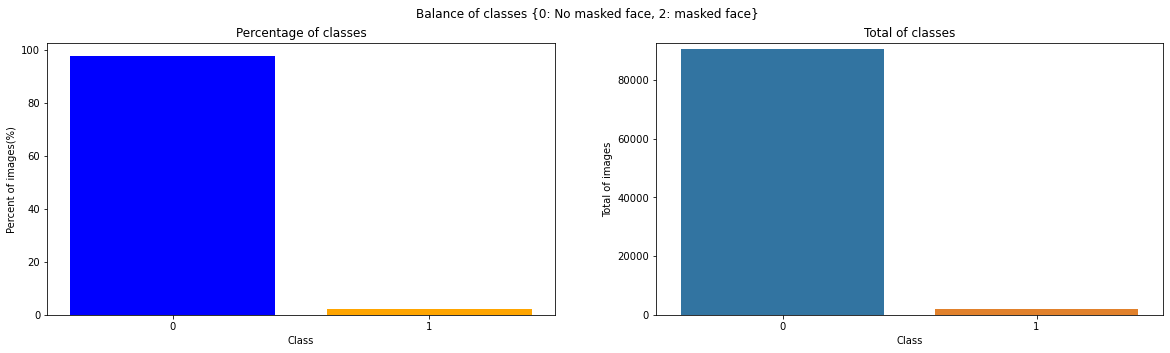

In [5]:
count = df["Labels"].value_counts()
percentCount = df["Labels"].value_counts(normalize = True)
print(count)

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle("Balance of classes {0: No masked face, 2: masked face}")
ax[0].bar(percentCount.index.astype(str), percentCount.values * 100, color = ("blue", "orange"))
ax[0].set_title("Percentage of classes")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Percent of images(%)")

sns.countplot(x = "Labels", data = df)
ax[1].set_title("Total of classes")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Total of images")
ax[1].set_ylim(0, count.sum())
plt.show()

you can see more no mask cases than mask cases, this problem is called imbalanced data set, this fact must be taken to make a decision in the model development.

In [6]:
d = {1: "True", 0: "False"}
df["Labels"] = df["Labels"].map(d)
df.sample(5)

,Files,Labels,Path
4719,1_0_benxi_0037.jpg,False,.\False\benxi\1_0_benxi_0037.jpg
23322,1_0_huangxiaoming_0173.jpg,False,.\False\huangxiaoming\1_0_huangxiaoming_0173.jpg
82694,1_0_zhangluyi_0115.jpg,False,.\False\zhangluyi\1_0_zhangluyi_0115.jpg
33295,0_0_likeqin_0120.jpg,False,.\False\likeqin\0_0_likeqin_0120.jpg
85098,1_0_zhangyimu_0104.jpg,False,.\False\zhangyimu\1_0_zhangyimu_0104.jpg


### Splitting data set to train, validate and test the model (split ratio 80% - 20%)
In this step, how data set is imbalanced, it is necessary to split a sample from the majority class to have a balanced data set to avoid overfitting over the majority class

In [7]:
seed = 0

minorityClass = df[df.Labels == "True"]
print('Minority class examples: ', minorityClass.shape[0])

majorityClass = df[df.Labels == "False"]
print('Majority class examples: ', majorityClass.shape[0])

resampledClass = sklearn.utils.resample(majorityClass, replace = False, n_samples = minorityClass.shape[0], random_state = seed)
print('Resampled class examples: ', resampledClass.shape[0])

dfBalanced = pd.concat([minorityClass, resampledClass])

dfFullTrain, dfTest = train_test_split(dfBalanced, test_size = 0.2, stratify = dfBalanced.Labels, random_state = seed)
dfTrain, dfValid = train_test_split(dfFullTrain, test_size = 0.2, stratify = dfFullTrain.Labels, random_state = seed)
image_size = (128, 128)

Minority class examples:  2118
Majority class examples:  90468
Resampled class examples:  2118


In [8]:
print(dfTrain.shape, dfValid.shape, dfTest.shape)

(2710, 3) (678, 3) (848, 3)


The model will be trained using 2710 images, validated using 678 images and tested using 848 images.

### Applying data augmentation
To increase the variation of the training data set, It is important to apply data augmentation to transform the images using flips, rotations, translations and to set different brightness to cover the possibilities when the model is in production.

In [9]:
batch_size = 32
train = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                           vertical_flip = True,
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=45, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                           brightness_range = (0.2, 2)
                           )

# Data generator for validation does not include random modifications
valid = ImageDataGenerator(rescale=1. / 255.0)

genTrain = train.flow_from_dataframe(  dataframe=dfTrain, 
                                         directory=None, 
                                         x_col = 'Path',
                                         y_col = 'Labels',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = batch_size,
                                        #color_mode = "grayscale",
                                         )

genValid = train.flow_from_dataframe(dataframe=dfValid, 
                                  directory=None, 
                                  x_col = 'Path',
                                  y_col = 'Labels',
                                  class_mode = 'binary',
                                  target_size = image_size, 
                                  batch_size = batch_size,
                                  #color_mode = "grayscale",
                                  )

genTest = valid.flow_from_dataframe(dataframe=dfTest, 
                                  directory=None, 
                                  x_col = 'Path',
                                  y_col = 'Labels',
                                  class_mode = 'binary',
                                  target_size = image_size, 
                                  batch_size = batch_size, 
                                  #color_mode = "grayscale",
                                  )

Found 2710 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 848 validated image filenames belonging to 2 classes.


### An example after applying data augmentation

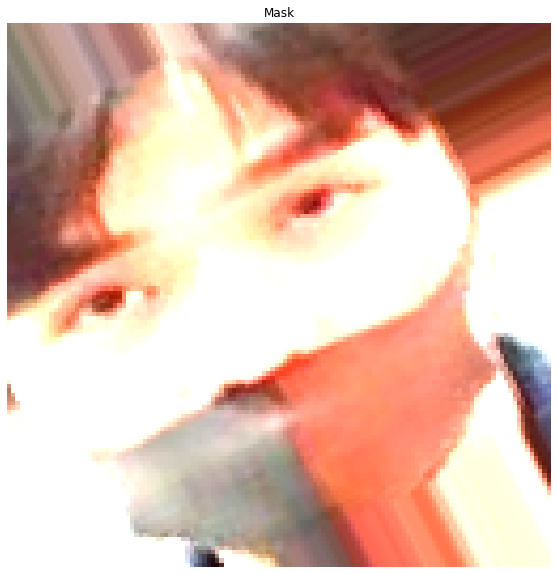

In [10]:
t_x, t_y = next(genTrain)
fig, m_axs = plt.subplots(1, 1, figsize = (10, 10))
for (c_x, c_y) in zip(t_x, t_y):
    plt.imshow(c_x[:,:,:], cmap = 'bone')
    if c_y == 1: 
        plt.title('Mask')
    else:
        plt.title('No Mask')
    plt.axis('off')

### Convolutional neural network architecture
It will be developed a sequential CNN model with four convolutional layers, a dropout, two neural layers and an output using the sigmoid function to classify the image. Simple to be used in real - time production. 

In [11]:
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.keras.applications import Xception

conv_base = Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (image_size[0], image_size[1], 3) 
)

conv_base.trainable = False
model = Sequential([
    conv_base,

    Flatten(),
    
    Dropout(0.5),
    
    Dense(8, activation = "relu"), 
    Dropout(0.25),
    Dense(8, activation = "relu"),
    #Dense(512, activation = "relu"), 
    #Dense(512, activation = "relu"),

    
    Dense(1, activation = "sigmoid")
])

In [12]:
model.compile(loss = "binary_crossentropy",
             optimizer = keras.optimizers.Adagrad(learning_rate = 1e-3),
             metrics = [
                        keras.metrics.BinaryAccuracy(name='accuracy'),
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall')
                       ])

callbackList = [keras.callbacks.EarlyStopping(patience = 10,
                                              restore_best_weights = True),
                keras.callbacks.ModelCheckpoint("../Model/bestModel.h5",
                                               save_best_only = True)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 262152    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

The best model will be saved after five epochs. I set five epoch to prevent the model from overfitting on the specifics of the images.

In [13]:
history = model.fit(genTrain, epochs = 1000,
                   validation_data = genValid,
                    callbacks = callbackList)

Epoch 1/1000
85/85 [==============================] - 145s 2s/step - loss: 0.3959 - accuracy: 0.8159 - precision: 0.8328 - recall: 0.7904 - val_loss: 0.1840 - val_accuracy: 0.9277 - val_precision: 0.9215 - val_recall: 0.9351
Epoch 2/1000
85/85 [==============================] - 145s 2s/step - loss: 0.2710 - accuracy: 0.8838 - precision: 0.8933 - recall: 0.8716 - val_loss: 0.1642 - val_accuracy: 0.9336 - val_precision: 0.9273 - val_recall: 0.9410
Epoch 3/1000
85/85 [==============================] - 143s 2s/step - loss: 0.2352 - accuracy: 0.9022 - precision: 0.9179 - recall: 0.8834 - val_loss: 0.1448 - val_accuracy: 0.9410 - val_precision: 0.9235 - val_recall: 0.9617
Epoch 4/1000
85/85 [==============================] - 144s 2s/step - loss: 0.2158 - accuracy: 0.9173 - precision: 0.9294 - recall: 0.9033 - val_loss: 0.1391 - val_accuracy: 0.9440 - val_precision: 0.9388 - val_recall: 0.9499
Epoch 5/1000
85/85 [==============================] - 146s 2s/step - loss: 0.1912 - accuracy: 0.9317

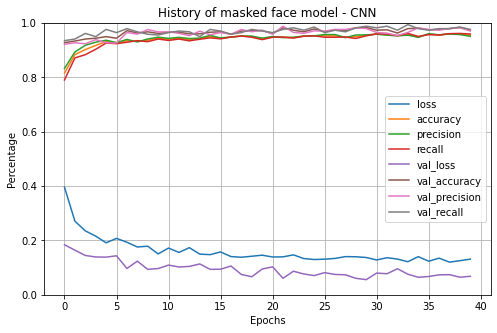

In [14]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid()
plt.gca().set_ylim(0, 1)
plt.gca().set_ylabel("Percentage")
plt.gca().set_xlabel("Epochs")
plt.gca().set_title("History of masked face model - CNN")
plt.show()

The model learnt during the epochs to improve the validation accuracy, precision and recall.

In [15]:
del model
keras.backend.clear_session()

In [16]:
np.random.seed(seed)
tf.random.set_seed(seed)
best_model = keras.models.load_model("../Model/bestModel.h5")
score = best_model.evaluate(genTest)

27/27 [==============================] - 35s 1s/step - loss: 0.0591 - accuracy: 0.9894 - precision: 0.9929 - recall: 0.9858


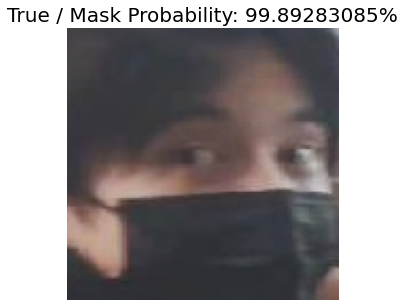

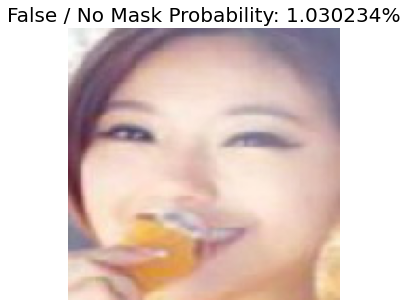

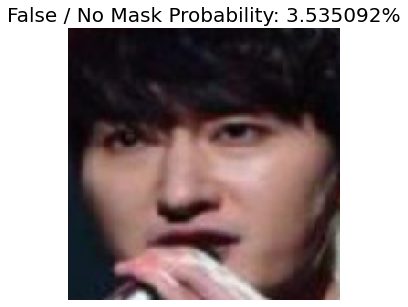

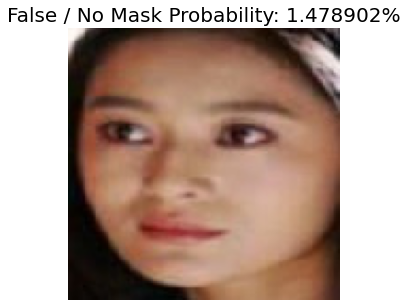

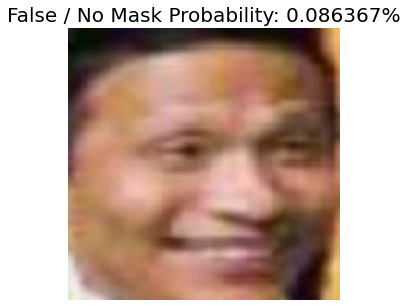

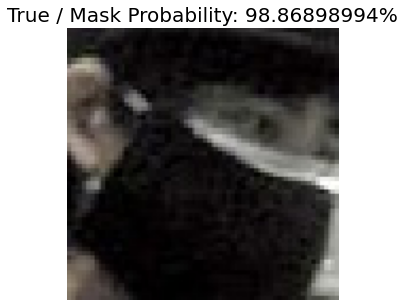

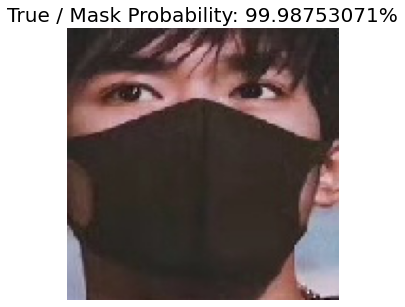

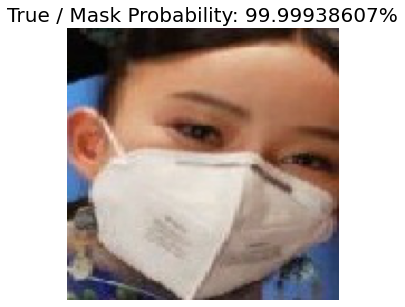

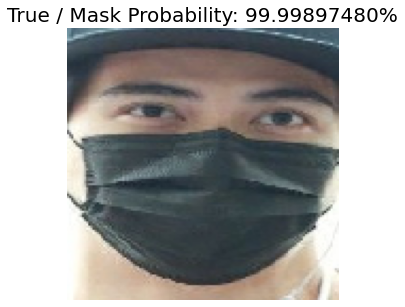

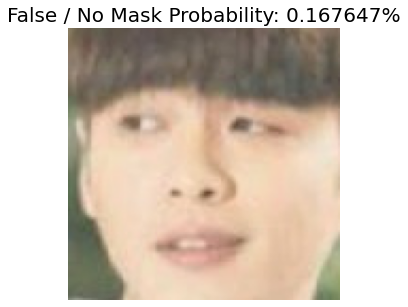

In [17]:
for _ in range(10):
    t_x, t_y = next(genTest)
    y_prob = best_model.predict(t_x)[:,0]
    y_pred = (y_prob>= 0.5).astype(bool)
    t_y = (t_y >= 0.5).astype(bool)
    #y_pred = (results["Predictions"]
    index = 0
    fig, m_axs = plt.subplots(1, 1, figsize = (5, 5))
    for (c_x, c_y) in zip(t_x, y_pred):
        plt.imshow(c_x[:,:,:], cmap = 'bone')
        if c_y == 1: 
            plt.title(str(t_y[index]) + ' / Mask Probability: {0:0.8f}%'.format(y_prob[index]*100), fontsize = 20)
        else:
            plt.title(str(t_y[index]) + ' / No Mask Probability: {0:0.6f}%'.format(y_prob[index]*100), fontsize = 20)
        plt.axis('off')
        index += 1

## Conclusion

In the training phase, the model presented the validation accuracy is higher than training accuracy, this can be explained because of the quantity of transformations for the data augmentation, the task to clssify if a person is wearing the mask or not becomes harder than classification of normal images. Another explaination is que quantity of used images to train, validate and test the model, it would be necessary increase the data set to give more cases to the model. On the other hand, the test accuracy, precision and sensitivity around of 99% tells the model is great to classify the images which there are masks or there are not and this model is ready to use it on the web page, wearthemask.herokuapp.com.